In [30]:
import pandas as pd
import numpy as np
import re
import nltk
import tensorflow as tf
import tensorflow_hub as hub
from keras.models import Model
from nltk.corpus import stopwords

from numpy import array
from keras.datasets import imdb
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers.core import Reshape
from keras.layers import Flatten, Conv2D, MaxPooling2D
from keras.layers import Conv1D, LSTM, GRU, Bidirectional, CuDNNGRU, CuDNNLSTM, BatchNormalization
from keras.layers import GlobalMaxPooling1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

In [2]:
movie_reviews = pd.read_csv("IMDB Dataset.csv")

movie_reviews.isnull().values.any()

movie_reviews.shape
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


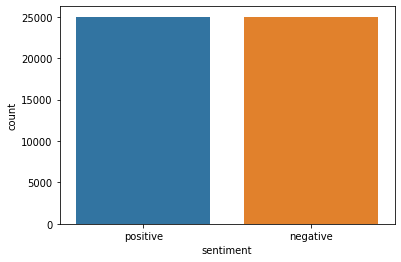

In [3]:
import seaborn as sns

sns.countplot(x='sentiment', data=movie_reviews)

In [4]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))
    
y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [6]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [7]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [8]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [9]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [10]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 10001     
Total params: 9,264,701
Trainable params: 10,001
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [11]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 1s 44us/step - loss: 0.5980 - acc: 0.6764 - val_loss: 0.5310 - val_acc: 0.7333
Epoch 2/6
32000/32000 [==============================] - 1s 38us/step - loss: 0.4944 - acc: 0.7643 - val_loss: 0.5187 - val_acc: 0.7421
Epoch 3/6
32000/32000 [==============================] - 1s 38us/step - loss: 0.4569 - acc: 0.7868 - val_loss: 0.5150 - val_acc: 0.7469
Epoch 4/6
32000/32000 [==============================] - 1s 38us/step - loss: 0.4333 - acc: 0.8006 - val_loss: 0.5257 - val_acc: 0.7429
Epoch 5/6
32000/32000 [==============================] - 1s 38us/step - loss: 0.4207 - acc: 0.8088 - val_loss: 0.5296 - val_acc: 0.7448
Epoch 6/6
32000/32000 [==============================] - 1s 39us/step - loss: 0.4086 - acc: 0.8141 - val_loss: 0.5357 - val_acc: 0.7408


In [12]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0]*100)
print("Test Accuracy:", score[1]*100)

10000/10000 [==============================] - 0s 43us/step
Test Score: 53.67218564033508
Test Accuracy: 73.90999794006348


In [13]:
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 9,318,957
Trainable params: 64,257
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [14]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0]*100)
print("Test Accuracy:", score[1]*100)

Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 19s 589us/step - loss: 0.5207 - acc: 0.7383 - val_loss: 0.4038 - val_acc: 0.8195
Epoch 2/6
32000/32000 [==============================] - 19s 583us/step - loss: 0.3743 - acc: 0.8346 - val_loss: 0.3723 - val_acc: 0.8305
Epoch 3/6
32000/32000 [==============================] - 20s 616us/step - loss: 0.3263 - acc: 0.8611 - val_loss: 0.3633 - val_acc: 0.8372
Epoch 4/6
32000/32000 [==============================] - 19s 592us/step - loss: 0.2882 - acc: 0.8817 - val_loss: 0.3658 - val_acc: 0.8355
Epoch 5/6
32000/32000 [==============================] - 19s 597us/step - loss: 0.2589 - acc: 0.8967 - val_loss: 0.3709 - val_acc: 0.8334
Epoch 6/6
10000/10000 [==============================] - 2s 230us/step
Test Score: 34.128243350982665
Test Accuracy: 84.92000102996826


In [15]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score [LSTM]:", score[0]*100)
print("Test Accuracy [LSTM]:", score[1]*100)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 9,372,077
Trainable params: 117,377
Non-trainable params: 9,254,700
_________________________________________________________________
None
Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 80s 3ms/step - loss: 0.5601 - acc: 0.7053 - val_loss: 0.5069 - val_acc: 0.7654
Epoch 2/6
32000/32000 [==============================] - 84s 3ms/step - loss: 0.4503 - acc: 0.7879 - val_loss: 0.4321 - val_acc: 0.8140
Epoch 3/6
32000/32000 [===================

In [16]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size = 2))

model.add(Bidirectional(LSTM(128)))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score [conv1D + LSTM]:", score[0])
print("Test Accuracy [conv1D + LSTM]:", score[1])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 100, 128)          64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 128)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 9,582,253
Trainable params: 327,553
Non-trainable params: 9,254,700
_________________________________________________________________
None
Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [===========================

In [17]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size = 2))

model.add(Bidirectional(GRU(128)))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score [conv1D + GRU]:", score[0])
print("Test Accuracy [conv1D + GRU]:", score[1])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 100, 128)          64128     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 50, 128)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               197376    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 9,516,461
Trainable params: 261,761
Non-trainable params: 9,254,700
_________________________________________________________________
None
Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [===========================

### (IMPROVEMENT(COMPLEX MODEL)

In [37]:


model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(512, 5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size = 2))

model.add(Conv1D(256, 5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size = 2))

model.add(Conv1D(256, 5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size = 2))

model.add(Bidirectional(LSTM(128)))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score [conv1D + LSTM]:", score[0])
print("Test Accuracy [conv1D + LSTM]:", score[1])

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 100, 100)          9254700   
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 100, 512)          256512    
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 50, 512)           0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 50, 256)           655616    
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 25, 256)           0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 25, 256)           327936    
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 12, 256)         